Loaded 100 validation trials
All files found.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 792ms/step

Validation Accuracy: 0.1667


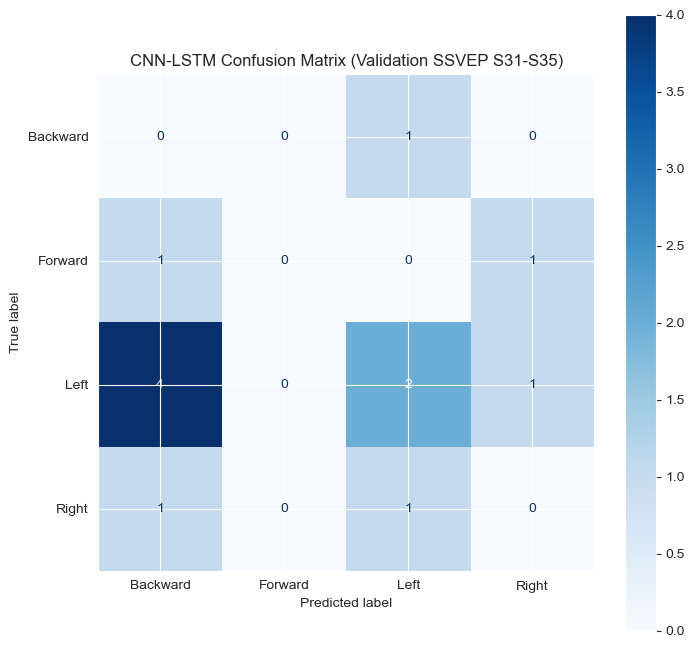

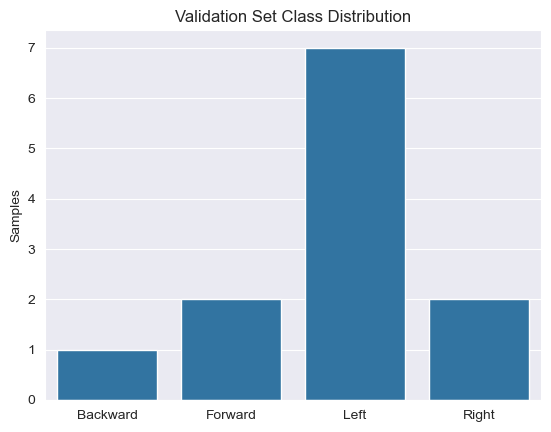

In [5]:
import os
import numpy as np
import pandas as pd
from keras.models import load_model
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

# --- CONFIG ---
base_dir = r"C:\Users\zezom\PycharmProjects\HorusEye"
validate_dir = os.path.join(base_dir, "Data", "Validate", "SSVEP")
channels = ['C3_ref', 'CZ_ref', 'C4_ref', 'OZ_ref']
samples_per_trial = 1750
model_path = model_path = r"C:\Users\zezom\PycharmProjects\HorusEye\cnn_lstm_ssvep_final.keras"
validation_csv_path = r"C:\Users\zezom\PycharmProjects\HorusEye\validation.csv"  # Make sure validation.csv is in your current directory!

# --- Load validation metadata ---
val_df = pd.read_csv(validation_csv_path)
val_df = val_df[val_df['label'].isin(['Backward', 'Forward', 'Left', 'Right'])]
val_df['subject_id'] = val_df['subject_id'].astype(str)
print(f"Loaded {len(val_df)} validation trials")

# --- Load and preprocess validation EEG data ---
X_val, y_val = [], []
missing_files = []
for _, row in val_df.iterrows():
    file = f"{row['subject_id']}_{row['trial_session']}_EEGdata_preprocessed.csv"
    file_path = os.path.join(validate_dir, file)
    if not os.path.exists(file_path):
        missing_files.append(file_path)
        continue
    df = pd.read_csv(file_path)
    start = (row['trial'] - 1) * samples_per_trial
    end = row['trial'] * samples_per_trial
    trial_data = df[channels].iloc[start:end].values.T
    if trial_data.shape[1] == samples_per_trial:
        X_val.append(trial_data)
        y_val.append(row['label'])

if missing_files:
    print(f"Missing files: {missing_files}")
else:
    print("All files found.")

X_val = np.array(X_val)
# Z-score normalize (per trial, per channel)
X_val = (X_val - X_val.mean(axis=-1, keepdims=True)) / (X_val.std(axis=-1, keepdims=True) + 1e-6)

# --- Label encode ---
le = LabelEncoder()
le.fit(['Backward', 'Forward', 'Left', 'Right'])
y_val_enc = le.transform(y_val)

# --- Load model ---
model = load_model(model_path)

# --- Predict ---
y_pred = np.argmax(model.predict(X_val), axis=1)

# --- Metrics ---
acc = accuracy_score(y_val_enc, y_pred)
print(f"\nValidation Accuracy: {acc:.4f}")

cm = confusion_matrix(y_val_enc, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=le.classes_)
fig, ax = plt.subplots(figsize=(8,8))
disp.plot(ax=ax, cmap='Blues')
plt.title("CNN-LSTM Confusion Matrix (Validation SSVEP S31-S35)")
plt.show()

# --- Class distribution ---
sns.barplot(x=le.classes_, y=[np.sum(np.array(y_val_enc)==i) for i in range(4)])
plt.title("Validation Set Class Distribution")
plt.ylabel("Samples")
plt.show()
